# Create DeepLab Semantic Segmentation Models using MZModel

This example shows you how to use the `dlpy.mzmodel` subpackage to create a DeepLab model to perform semantic segmentation. The `dlpy.mzmodel` subpackage leverages the [SAS Deep Learning Model Zoo](https://go.documentation.sas.com/doc/en/pgmsascdc/latest/casdlmzpg/titlepage.htm) utilities to manage deep learning models on the CAS server.

## Table of Contents
1. [Set Up Environment](#setup)
2. [Load and Visualize Self-driving Data](#prepare)
3. [Build the Model](#build)
4. [Train the Model](#train)
5. [Score the Model and Visualize Scoring Results](#score)

## Set Up Environment <a id="setup"><a>

First, import the various Python and SAS DLPy packages that will be used in this notebook session. Begin by importing the SAS Statistical Wrapper for Analytic Transactions (SWAT). SWAT is the Python interface to SAS CAS. Here is more information about [starting a SAS CAS session with the SWAT package](https://sassoftware.github.io/python-swat/getting-started.html).

In [1]:
import swat as sw
import sys
from dlpy.mzmodel import *
from dlpy.utils import *

Create a CAS session instance. Provide connection information to your running CAS server. For this example, assume the CAS server is hosted at `cloud.example.com` on port `5570`.

In [2]:
s = sw.CAS('cloud.example.com', 5570)

## Load and Visualize Self-driving Data <a id="prepare"></a>

Data is available at https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge (CARLA: An Open Urban Driving Simulator https://arxiv.org/abs/1711.03938). Training data can be created following https://github.com/sassoftware/python-dlpy/blob/master/examples/segmentation/image_segmentation_data_preparation.ipynb.

In [3]:
s.table.addcaslib(activeonadd=False,
                  datasource={'srctype':'path'},
                  name='dnfs',
                  path='/path/to/data',
                  subdirectories=True)

NOTE: Cloud Analytic Services added the caslib 'dnfs'.


,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
0,dnfs,PATH,,/path/to/data/,,1.0,1.0,0.0,0.0,0.0,0.0


In [4]:
s.table.loadTable(caslib='dnfs', path='self_driving/self_driving_256_train.sashdat', 
    casout = dict(name = 'train', replace = True))

NOTE: Cloud Analytic Services made the file self_driving/self_driving_256_train.sashdat available as table TRAIN in caslib CASUSER(userID).


[caslib]

 'CASUSER(userID)'

[tableName]

 'TRAIN'

[casTable]

 CASTable('TRAIN', caslib='CASUSER(userID)')

+ Elapsed: 0.00402s, user: 0.00132s, sys: 0.00137s, mem: 0.734mb

In [5]:
s.table.loadTable(caslib='dnfs', path='self_driving/self_driving_256_test.sashdat', 
    casout = dict(name = 'test', blocksize = '1', replace = True))

NOTE: Cloud Analytic Services made the file self_driving/self_driving_256_test.sashdat available as table TEST in caslib CASUSER(userID).


[caslib]

 'CASUSER(userID)'

[tableName]

 'TEST'

[casTable]

 CASTable('TEST', caslib='CASUSER(userID)')

+ Elapsed: 0.00238s, user: 0.0016s, mem: 0.718mb

The source data that was loaded into CAS table data contains both raw images and annotated (ground truth) image segmentations. Use the `display_segmentation_images()` function to visualize four raw input images and their corresponding ground truth segmentation.

NOTE: The HISTOGRAM_EQUALIZATION function accepts only images whose depth is 8-bit unsigned character.
NOTE: The table TRAIN contains encoded images.
NOTE: 683 of 683 images were processed successfully and saved as encoded images to the Cloud Analytic Services table segmentationImageProcessed_JzbAGU.


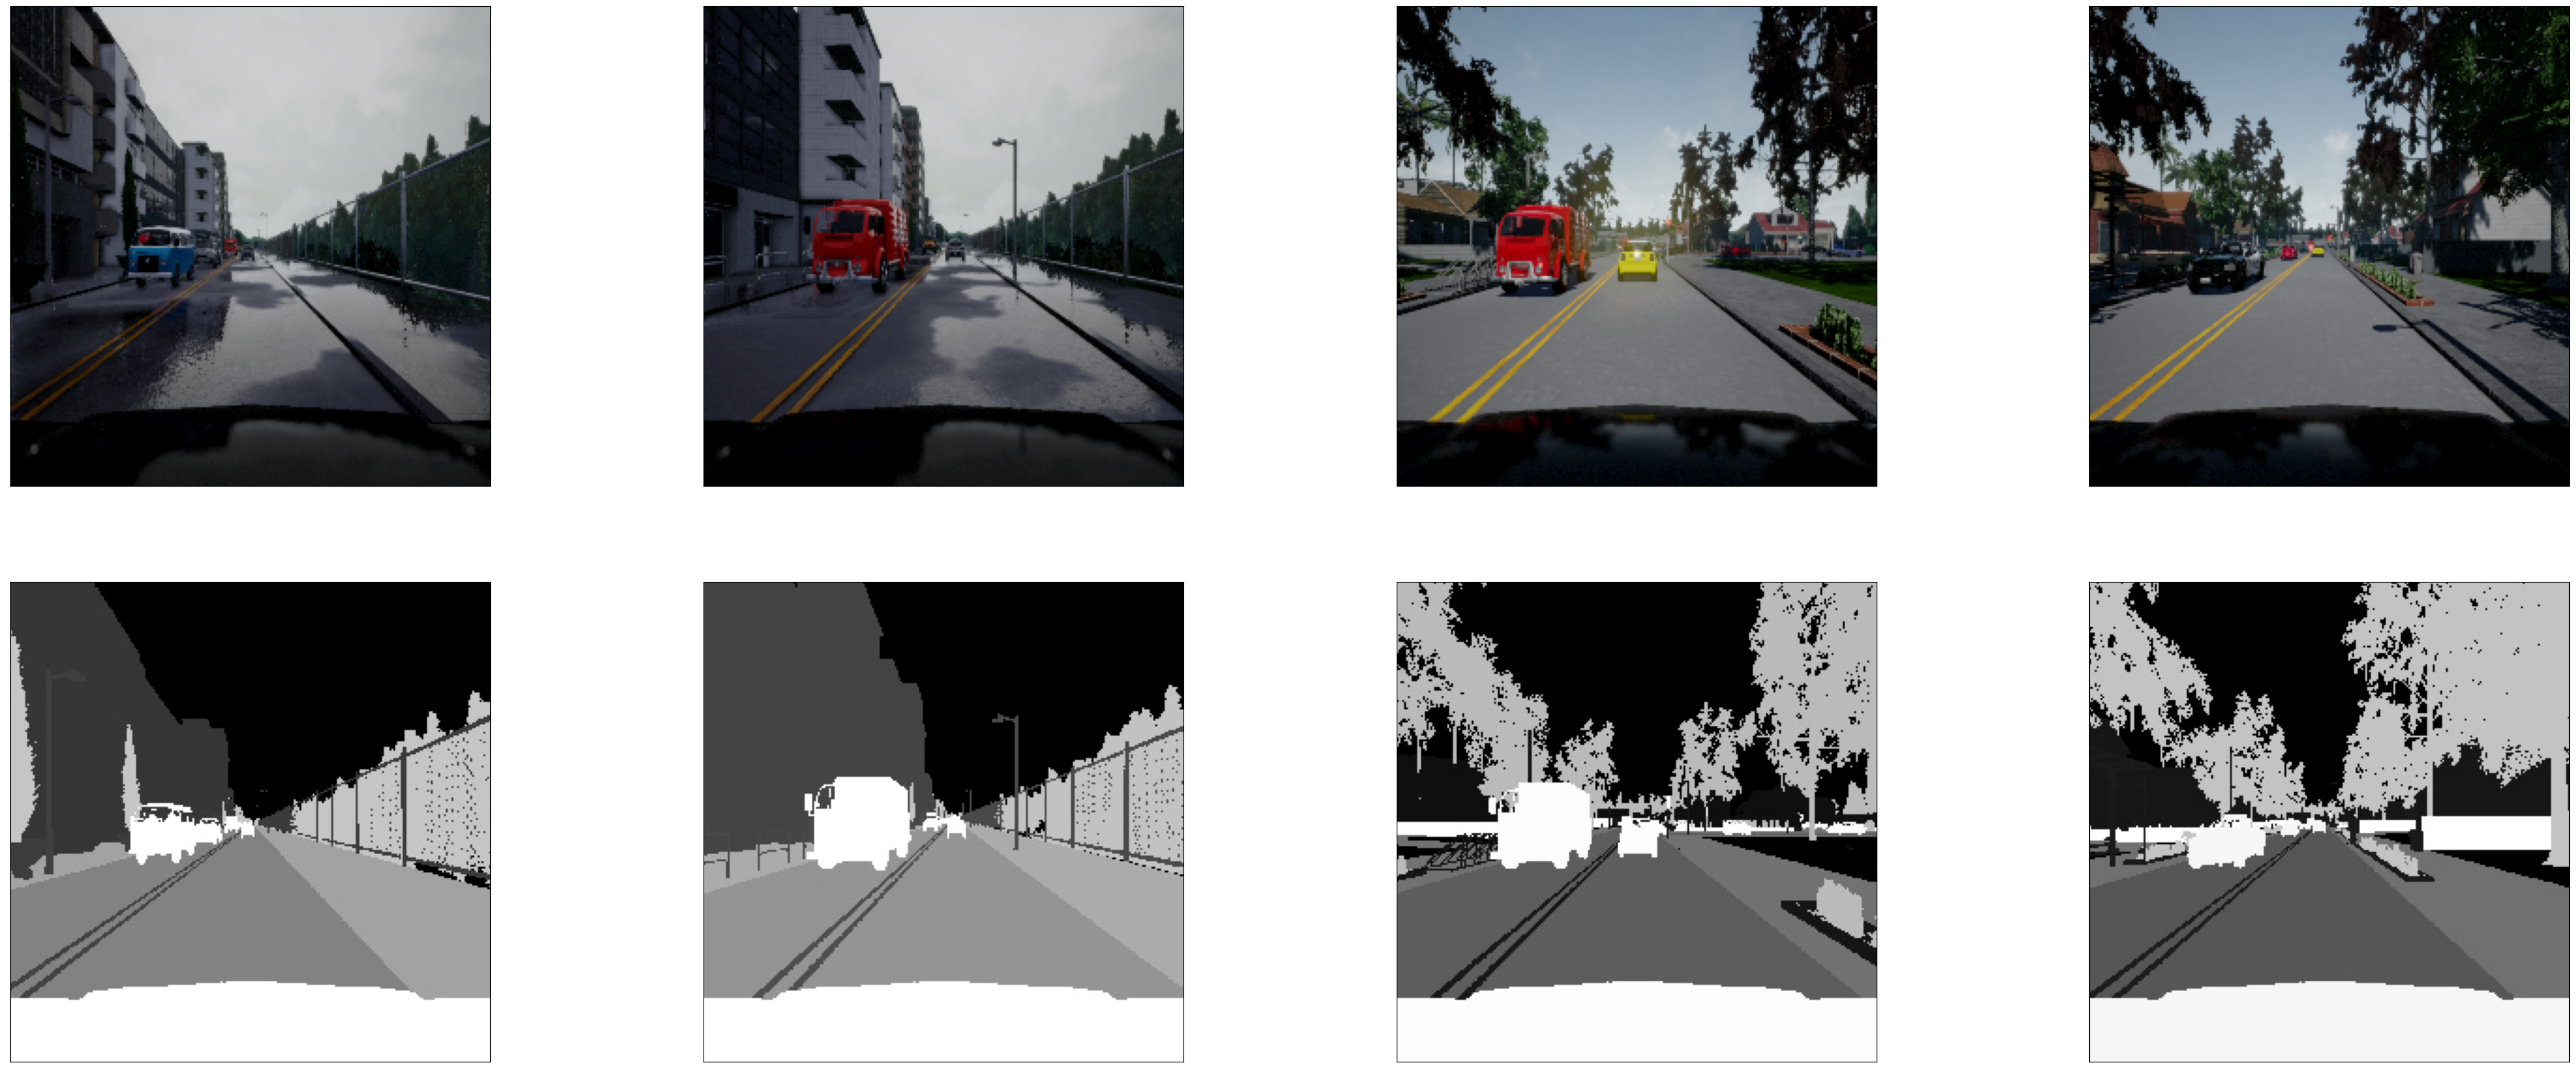

In [6]:
display_segmentation_images(s, 'train', n_images=4, segmentation_labels_table='train')

## Build the Model <a id="build"></a>

Create a DeepLab model by using the `MZModel()` constructor. This model is a TorchScript model, meaning the model structure and necessary functions are defined in a .pt file. To use a TorchScript model, you can specify `type="torchScript"` and set the `model_path` to the path of the file that contains the information mentioned above.

In [7]:
model = MZModel(conn=s, 
                model_type = "torchScript", 
                dataset_type='segmentation', 
                num_classes=13, 
                model_path = "/path/to/model/deeplab_wrapped.pt")

# Train the Model <a id="train"></a>

Use the `train()` method of the `MZModel` class to train the DeepLab model. Use `inputs` to specify the column that contains the raw images and `targets` to specify the column that containst the annotation images. Pass your optimizer and gpu settings.

In [8]:
optimizer=Optimizer(seed=12345, 
                    algorithm=SGDSolver(lr=0.01),
                    batch_size=10,
                    max_epochs=10                   
                    )

In [9]:
model.train(table='train', inputs='_image_', targets='labels', gpu=[0], n_threads=4, optimizer=optimizer)

NOTE: No target map from nominal values to numeric values is found.
NOTE: Using this GPU List on your-server.unx.company.com: [0 ].
NOTE: Worker rank 0: your-server.unx.company.com, using up to 1 GPU devices.
NOTE: Using your-server.unx.company.com: GPU 0 processes up to 10 records at a time.
NOTE: Starting dlxexe process on worker your-server.unx.company.com, rank/threadID [0/0], pid= 61727 device= GPU:0
NOTE: Learning Rate:    0.01 Momentum:     0.9 Weight Decay:       0 Dampening:       0 BatchSize: 10 Rank: 0 Device: 0 Loss: 138.796
NOTE: The action completed successfully.


,Epoch,Loss,MCE,mIoU
0,0.0,560.809057,0.247624,0.227204
1,1.0,273.306602,0.128813,0.547044
2,2.0,208.727601,0.101444,0.585807
3,3.0,179.373502,0.089519,0.617942
4,4.0,164.986742,0.084560,0.636329
5,5.0,157.849792,0.082507,0.645564
6,6.0,152.838558,0.081486,0.650342
7,7.0,146.585276,0.079252,0.657224
8,8.0,141.603804,0.077494,0.663816
9,9.0,138.795599,0.076736,0.668560


## Score the Model and Visualize Scoring Results <a id="score"></a>

Use the `MZModel.score()` method to score the test data. When you run the `MZModel.score()` method, the score results are written to `MZModel.table_out`. The `MZModel.table_out` value is a `CASTable` that contains the labels in the `labels` column, the annotated image predictions in the `_predImg_` column, and the filename in the `_filename_0` column.

In [10]:
model.score(table="test", inputs='_image_', targets='labels', gpu=[0], batch_size=128)

NOTE: Using this GPU List on your-server.unx.company.com: [0 ].
NOTE: No target map from nominal values to numeric values is found.
NOTE: In the score output, expected nominal values will be in raw numeric representation.
NOTE: Worker rank 0: your-server.unx.company.com, using up to 1 GPU devices.
NOTE: Using your-server.unx.company.com: GPU 0 processes up to 128 records at a time.
NOTE: Using existing dlxexe process on worker your-server.unx.company.com, rank/threadID [0/0], pid= 61727 device= GPU:0
NOTE: The action completed successfully.


,Loss,MCE,mIoU
0,43.178482,0.175643,0.544468


Use the `display_segmentation_results()` function to display  rows of scored images from the validation table for the model model. There should 3 columns in the table: raw image, ground truth segmentation, and predicted segmentation.

NOTE: The HISTOGRAM_EQUALIZATION function accepts only images whose depth is 8-bit unsigned character.
NOTE: The table TABLE_WU0I5T contains encoded images.
NOTE: 67 of 67 images were processed successfully and saved as encoded images to the Cloud Analytic Services table labelImageProcessed_ZCVHrd.
NOTE: The HISTOGRAM_EQUALIZATION function accepts only images whose depth is 8-bit unsigned character.
NOTE: The table LABELIMAGEPROCESSED_ZCVHRD contains encoded images.
NOTE: 67 of 67 images were processed successfully and saved as encoded images to the Cloud Analytic Services table allImageProcessed_dEDGvo.
5


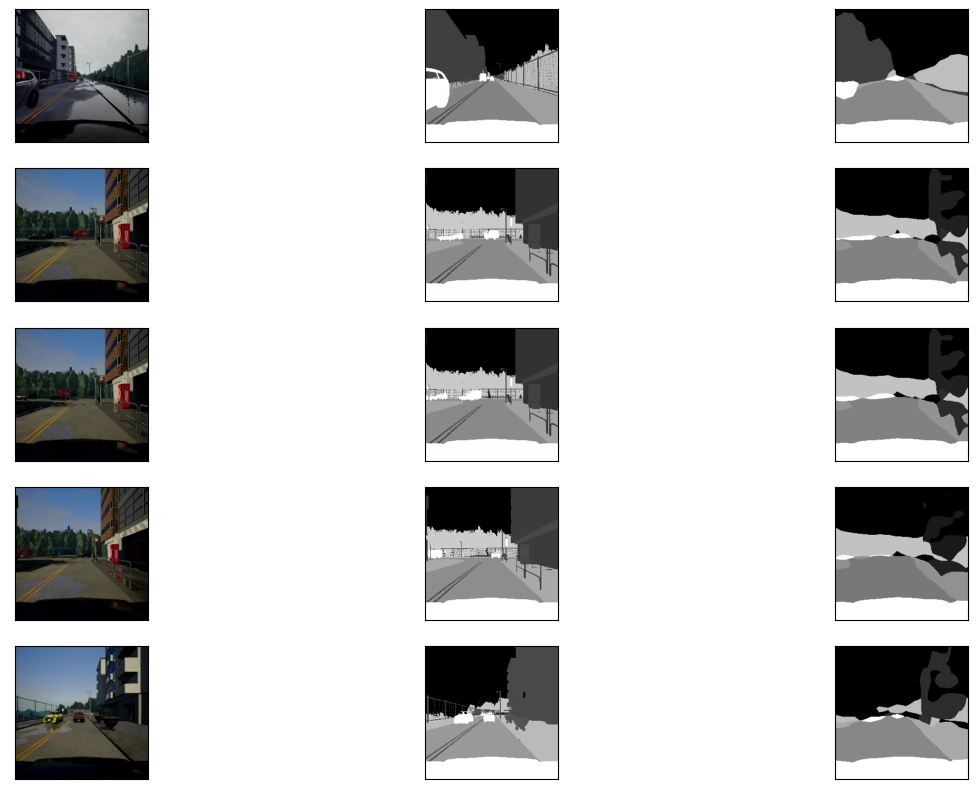

In [11]:
display_segmentation_results(s, 
                             model.table_out, 
                             n_images=5, 
                             segmentation_labels_table=model.table_out,
                             segmentation_prediction_table=model.table_out,
                             prediction_column='_predImg_',
                             filename_column='_filename_0',
                             fig_size=(15,10))